In [225]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim.corpora.dictionary import Dictionary
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
wnl = WordNetLemmatizer()

In [239]:
path = r'C:\Users\Yunseok Choi\Downloads\TP Articles for LDA'
text_list = os.listdir(path)
cps_list = []
cps_name = []
for i in range(12):
    globals()['cps{}'.format(i+1)] = open(path+'\\'+text_list[i], encoding='utf8').read().lower().replace('\n', ' ')
    cps_name.append('cps{}'.format(i+1))
    cps_list.append(globals()['cps{}'.format(i+1)])

In [240]:
stword = stopwords.words('english')
#Stopword 추가
stword_add = ['one','two','three','four','five','six','seven','eight','nine','ten', 'increasing','decreasing',
              'half','must','say','said','able','therefore','higher','lower','better','asking','largerst','smallest','come',
             'th','highest','lowest','whatever','help','v','c','high','low','iii','i','ii','iv','v','vi','vii','viii','every',
             'first','second','third','fourth','fifth','sixth','seventh','eighth', 'also', 'table', 'fig']
stword.extend(stword_add)

In [241]:
#Corpus별 표제어(lemmatization) 추출
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()
texts = []
for item in cps_list:
    #corpus 속 숫자 제거
    temp = re.sub('[0-9]+','',item)
    tokens = tokenizer.tokenize(temp)
    #1글자로 이루어진 단어 제거
    tokens_overone = [word for word in tokens if len(word) > 1]
    #stopword 제거
    stopped_tokens = [i for i in tokens_overone if not i in stword]    
    # ing형 제거
    noning_tokens = [word for word in stopped_tokens if (re.findall('ing$', word) == [])]
    #각 단어 표제화
    lemmatized_words = [wnl.lemmatize(i) for i in noning_tokens]
    texts.append(lemmatized_words)

In [242]:
#Defining functino for plotting with word frequency limitation as input.
def coherence_score(limit):
    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token]) ] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]

    #토픽의 개수별 gensim LDA 모델의 coherence score 체크
    coherence_values = []
    model_list = []
    for n_topics in range(2,13,1):
        model = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = n_topics, id2word = dictionary, 
                                         passes=15, alpha = 'symmetric', iterations = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    x = range(2,13,1)
    plt.plot(x, coherence_values)
    plt.title('Coherence Score of LDA (< {} Counts)'.format(limit))
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'),loc = 'best')
    return plt.show()

In [243]:
#defining print function of showing 15 keywords and document-topic information, 
#having word frequency limit and number of topics as input.
def lda_analysis(limit, num_tps):
    frequency = {}
    for corpus in texts:
        for word in corpus:
            if word in frequency.keys():
                frequency[word] +=1
            else:
                frequency[word] = 1
    texts_filtered = [ [token for token in text if (1 < frequency[token]<limit)] for text in texts ]

    #표제화된 단어들을 이용하여 document-term 테이블 생성
    dictionary = Dictionary(texts_filtered)
    docfreq = dictionary.dfs
    doc_term_matrix = [dictionary.doc2bow(i) for i in texts]
    
    global doc_term_matrix
    ldaModel = models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics = num_tps, id2word = dictionary, 
                                        passes=15, alpha = 'symmetric', iterations = 10)
    ldaTopics = ldaModel.print_topics(num_topics = num_tps, num_words = 15)
    temp = []
    for i in range(len(ldaTopics)):
        string = ''
        for item in ldaTopics[i][1].split('+'):
            string += (item.split('*')[1].replace(r'"','') + '')
        temp.append(['Topic ' + str(ldaTopics[i][0])] + [string.replace(' ',', ')])
    print(temp)
    for i in range(len(doc_term_matrix)):
        print(ldaModel[doc_term_matrix[i]])

6402


Text(0, 0.5, 'Frequency')

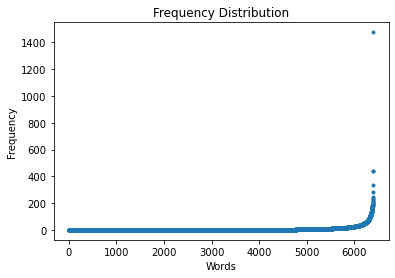

In [245]:
#Cheking the freqeuency distribution with all words.
term_dic = {}
for texts in doc_term_matrix:
    for item in texts:
        if item[0] in term_dic.keys():
            term_dic[item[0]] += item[1]
        else:
            term_dic[item[0]] = 1
term_dic_sorted = sorted(term_dic.items(), key = operator.itemgetter(1))
x , y = [] ,[]
for i in range(len(term_dic_sorted)):
    y.append(term_dic_sorted[i][1])
    x.append(i)
print(len(term_dic_sorted))
plt.plot(x,y, '.')
plt.title('Frequency Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

In [246]:
sorted(term_dic.items(), key = operator.itemgetter(1), reverse = True)

[(64, 1476),
 (1608, 442),
 (781, 437),
 (60, 333),
 (1819, 283),
 (392, 247),
 (1072, 241),
 (1595, 231),
 (440, 214),
 (658, 214),
 (29, 210),
 (1199, 199),
 (105, 197),
 (1395, 197),
 (862, 192),
 (579, 184),
 (1076, 182),
 (2007, 181),
 (445, 180),
 (294, 179),
 (829, 173),
 (506, 161),
 (847, 158),
 (366, 157),
 (836, 157),
 (121, 156),
 (1756, 156),
 (930, 155),
 (1150, 155),
 (1249, 154),
 (108, 148),
 (164, 147),
 (369, 142),
 (1066, 140),
 (1539, 140),
 (1706, 140),
 (723, 137),
 (1061, 136),
 (1761, 136),
 (509, 135),
 (229, 134),
 (949, 129),
 (975, 128),
 (1363, 127),
 (68, 125),
 (877, 125),
 (1510, 124),
 (1607, 124),
 (1310, 123),
 (1261, 120),
 (1000, 116),
 (1042, 116),
 (1617, 116),
 (1745, 116),
 (113, 115),
 (1481, 115),
 (86, 114),
 (583, 114),
 (992, 112),
 (1669, 112),
 (277, 109),
 (779, 108),
 (894, 108),
 (1093, 108),
 (590, 107),
 (578, 106),
 (1512, 106),
 (585, 105),
 (581, 104),
 (1221, 102),
 (1635, 102),
 (1368, 100),
 (1668, 100),
 (1707, 100),
 (989, 9

In [249]:
#counting words with only one frequency.
count = 0
for item in y:
    if item == 1:
        count +=1
count

3395

In [238]:
#checking the term using dictionary.
dictionary[1608]

'technology'

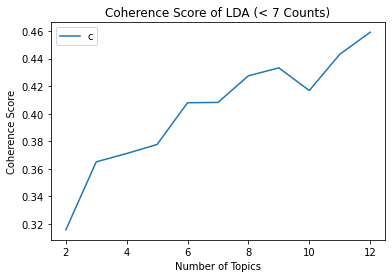

In [113]:
coherence_score(7)

In [180]:
lda_analysis(7,6)

[['Topic 0', 'ai, network, application, technology, operator, industry, could, new, regulation, company, country, would, data, service, market'], ['Topic 1', 'ai, quantum, technology, human, policy, data, european, system, algorithm, paper, national, development, ethical, research, issue'], ['Topic 2', 'ai, agent, firm, activity, economic, topic, collaboration, information, technology, area, type, number, technological, subdomains, human'], ['Topic 3', 'ai, china, ecosystem, innovation, company, research, government, technology, university, industry, model, development, national, analysis, main'], ['Topic 4', 'public, ai, system, sector, decision, government, service, data, automated, use, citizen, policy, governance, process, risk'], ['Topic 5', 'ai, human, law, ethical, technology, work, principle, question, legal, different, need, intelligence, state, machine, international']]
[(1, 0.02265307), (4, 0.95340645)]
[(0, 0.21919608), (1, 0.3664793), (2, 0.07694861), (3, 0.15240632), (4, 

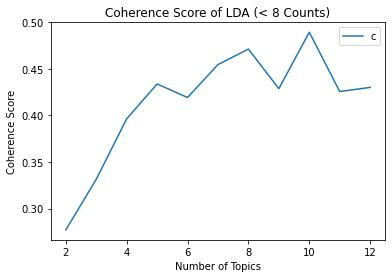

In [114]:
coherence_score(8)

In [181]:
lda_analysis(8,5)

[['Topic 0', 'ai, china, technology, government, public, innovation, ecosystem, company, system, research, development, policy, paper, sector, data'], ['Topic 1', 'ai, network, agent, activity, application, topic, collaboration, number, area, operator, data, industry, subdomains, type, technological'], ['Topic 2', 'human, ai, technology, system, work, question, ethical, data, european, algorithm, need, use, decision, right, weapon'], ['Topic 3', 'ai, firm, agent, human, economic, theory, information, technology, principal, machine, cost, asymmetry, new, like, labor'], ['Topic 4', 'ai, quantum, principle, intelligence, law, ethical, legal, different, technology, policy, artificial, human, development, state, national']]
[(0, 0.8524257), (2, 0.11133307), (4, 0.024027606)]
[(0, 0.53292304), (1, 0.042290676), (2, 0.23244615), (3, 0.07529402), (4, 0.11704617)]
[(0, 0.021466805), (1, 0.93559384), (2, 0.02495621), (4, 0.0127847)]
[(2, 0.03244174), (4, 0.9574565)]
[(0, 0.010339126), (2, 0.9598

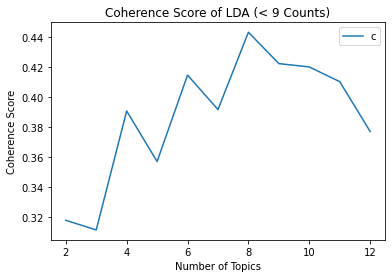

In [115]:
coherence_score(9)

In [182]:
lda_analysis(9,6)

[['Topic 0', 'ai, network, firm, agent, application, human, operator, industry, service, cost, data, new, economic, information, regulation'], ['Topic 1', 'quantum, technology, work, human, question, policy, technical, science, national, would, need, way, information, job, ai'], ['Topic 2', 'agent, activity, ai, topic, collaboration, area, number, subdomains, technological, type, u, firm, network, eu, thematic'], ['Topic 3', 'ai, china, technology, ecosystem, innovation, company, government, research, development, industry, country, university, model, policy, national'], ['Topic 4', 'ai, public, system, data, human, european, policy, decision, sector, government, technology, right, impact, ethical, algorithm'], ['Topic 5', 'ai, human, law, ethical, principle, legal, system, intelligence, different, technology, use, state, international, ethic, development']]
[(0, 0.01827086), (3, 0.029792273), (4, 0.9257657), (5, 0.019203365)]
[(0, 0.10948263), (1, 0.046597324), (2, 0.010584416), (3, 0

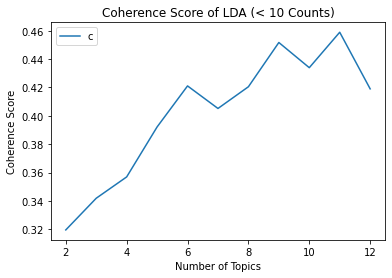

In [116]:
coherence_score(10)

In [183]:
lda_analysis(10,6)

[['Topic 0', 'quantum, technology, work, human, question, policy, national, technical, science, ai, would, intelligence, artificial, need, development'], ['Topic 1', 'agent, activity, ai, topic, collaboration, area, china, number, u, technological, subdomains, type, research, technology, eu'], ['Topic 2', 'ai, technology, international, state, country, china, law, development, different, legal, ethical, policy, would, principle, company'], ['Topic 3', 'ai, human, firm, agent, data, ethical, european, technology, economic, social, intelligence, ethic, right, machine, theory'], ['Topic 4', 'ai, network, china, ecosystem, industry, application, company, innovation, operator, government, university, service, regulation, case, data'], ['Topic 5', 'ai, system, human, public, decision, use, technology, sector, data, algorithm, government, weapon, law, service, ethical']]
[(2, 0.019509656), (3, 0.013139066), (4, 0.020911545), (5, 0.937278)]
[(0, 0.08264876), (1, 0.029615669), (2, 0.28306562), 

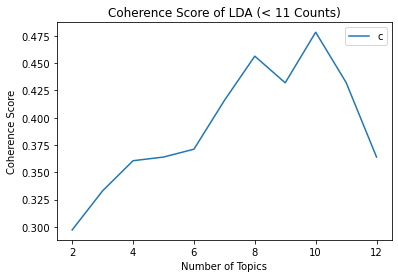

In [117]:
coherence_score(11)

In [184]:
lda_analysis(11,6)

[['Topic 0', 'agent, ai, activity, network, topic, collaboration, area, number, subdomains, type, technological, firm, u, eu, thematic'], ['Topic 1', 'ai, china, network, ecosystem, industry, company, innovation, different, application, intelligence, paper, development, law, regulation, legal'], ['Topic 2', 'ai, technology, activity, system, human, data, agent, research, different, china, policy, development, collaboration, application, network'], ['Topic 3', 'ai, firm, human, agent, work, technology, question, machine, economic, theory, technical, information, like, rather, would'], ['Topic 4', 'ai, technology, quantum, public, policy, system, development, government, decision, sector, data, state, use, new, national'], ['Topic 5', 'human, ai, ethical, european, data, system, algorithm, right, ethic, technology, social, policy, europe, impact, protection']]
[(1, 0.025911363), (4, 0.9249838), (5, 0.039089963)]
[(0, 0.022430643), (1, 0.38584644), (3, 0.09226571), (4, 0.32864353), (5, 0.

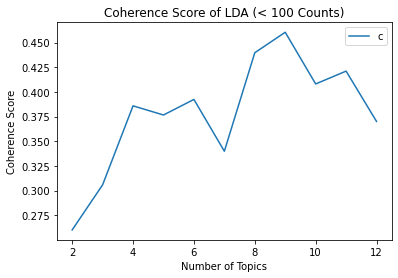

In [144]:
coherence_score(100)

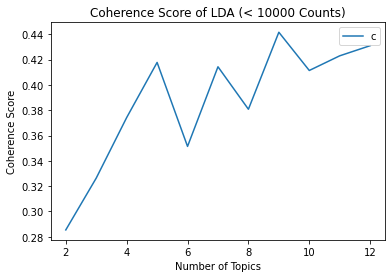

In [120]:
coherence_score(10000)

In [185]:
lda_analysis(10000, 5)

[['Topic 0', 'ai, network, application, operator, industry, regulation, telecommunication, service, could, customer, telecom, data, regulatory, new, cost'], ['Topic 1', 'agent, quantum, activity, ai, topic, technology, collaboration, area, information, research, number, technological, subdomains, policy, type'], ['Topic 2', 'ai, china, technology, human, development, law, ethical, ecosystem, innovation, company, state, principle, international, different, system'], ['Topic 3', 'ai, human, technology, firm, public, data, system, agent, work, question, european, decision, machine, policy, economic'], ['Topic 4', 'ai, human, system, technology, decision, ethical, data, use, agent, algorithm, activity, policy, public, research, development']]
[(0, 0.012153972), (1, 0.011879206), (2, 0.11319155), (3, 0.86273324)]
[(0, 0.033574834), (1, 0.029869575), (2, 0.54392505), (3, 0.3925003)]
[(0, 0.9921988)]
[(2, 0.9417369), (3, 0.052775793)]
[(2, 0.84805655), (3, 0.14219743)]
[(0, 0.010640954), (1, 